# Practical 2: GAN & Diffusion

## Task 1

In [315]:
!source lab2_env/bin/activate

In [316]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
import os
import wandb
from IPython.display import Image, display
import glob

In [317]:
# Hyperparameters
mb_size = 64    # mini‑batch size, num of real/fake samples feedeng through the NN before doing one gradient update
Z_dim = 1000    # dimensionality of the latent noise vector 
h_dim = 128     # size of the hidden layers in both generator and discriminator
lr = 1e-3       # learning rate for the optimizer

We need to normalize out data set to get pixels values from [0, 255] to [0,1] :

PIL:       255  →   Tensor: 1.0

PIL:       128  →   Tensor: 0.50196

PIL:         0  →   Tensor: 0.0

In [318]:
# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

Xavier initialization balances weights through layers 
by drawing a random number from a Gaussian (Normal) distribution,
whose mean is 0 and whose standard deviation is chosen according to the layer size.

In [319]:
# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [332]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))   # Sigmoid is possible because data was normalized in [0,1]
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out

In [333]:
# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())  # fake discrimination 

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)  # more 1 for fakes from D, better for G
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    """wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })"""

    return G, D, G_loss_avg, D_loss_avg

In [334]:
# Generator stopps to learn and only generates pictures
def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_vanila_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]    # We don't need to see all 64, 16 is enough to see progress

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)


In [323]:
# ########################### Training 5 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 5

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

loss_fn = my_bce_loss

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()


100%|██████████| 938/938 [00:13<00:00, 68.17it/s]


epoch 0; D_loss: 0.0802; G_loss: 5.9523
Saved Best Models at epoch 0 | G_loss: 5.9523


100%|██████████| 938/938 [00:13<00:00, 68.75it/s]


epoch 1; D_loss: 0.0295; G_loss: 6.7544


100%|██████████| 938/938 [00:13<00:00, 68.72it/s]


epoch 2; D_loss: 0.0244; G_loss: 6.1841


100%|██████████| 938/938 [00:13<00:00, 69.43it/s]


epoch 3; D_loss: 0.0446; G_loss: 6.1652


100%|██████████| 938/938 [00:13<00:00, 69.96it/s]


epoch 4; D_loss: 0.1042; G_loss: 5.6365
Saved Best Models at epoch 4 | G_loss: 5.6365


D_loss,▆▁▁▃█
G_loss,▃█▄▄▁
epoch,▁▃▅▆█
D_loss,0.10418
G_loss,5.63655
epoch,4


In [324]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)

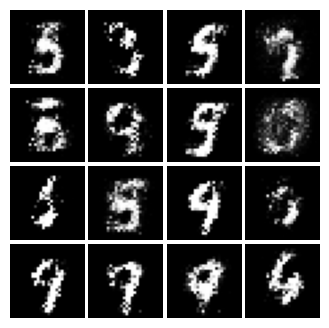

In [325]:
display(Image("best.png"))

In [329]:
# ########################### Training 10 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 10

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

loss_fn = my_bce_loss

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()


100%|██████████| 938/938 [00:13<00:00, 69.45it/s]


epoch 0; D_loss: 0.0717; G_loss: 6.2024
Saved Best Models at epoch 0 | G_loss: 6.2024


100%|██████████| 938/938 [00:13<00:00, 71.38it/s]


epoch 1; D_loss: 0.0251; G_loss: 6.6020


100%|██████████| 938/938 [00:13<00:00, 69.81it/s]


epoch 2; D_loss: 0.0531; G_loss: 5.5099
Saved Best Models at epoch 2 | G_loss: 5.5099


100%|██████████| 938/938 [00:13<00:00, 70.35it/s]


epoch 3; D_loss: 0.1181; G_loss: 5.3680
Saved Best Models at epoch 3 | G_loss: 5.3680


100%|██████████| 938/938 [00:13<00:00, 69.05it/s]


epoch 4; D_loss: 0.1978; G_loss: 5.1907
Saved Best Models at epoch 4 | G_loss: 5.1907


100%|██████████| 938/938 [00:12<00:00, 73.45it/s] 


epoch 5; D_loss: 0.3601; G_loss: 4.3227
Saved Best Models at epoch 5 | G_loss: 4.3227


100%|██████████| 938/938 [00:13<00:00, 68.76it/s]


epoch 6; D_loss: 0.4435; G_loss: 3.5738
Saved Best Models at epoch 6 | G_loss: 3.5738


100%|██████████| 938/938 [00:13<00:00, 68.88it/s]


epoch 7; D_loss: 0.5211; G_loss: 3.1740
Saved Best Models at epoch 7 | G_loss: 3.1740


100%|██████████| 938/938 [00:13<00:00, 70.68it/s]


epoch 8; D_loss: 0.6140; G_loss: 2.9517
Saved Best Models at epoch 8 | G_loss: 2.9517


100%|██████████| 938/938 [00:11<00:00, 84.46it/s] 


epoch 9; D_loss: 0.6213; G_loss: 2.7525
Saved Best Models at epoch 9 | G_loss: 2.7525


D_loss,▂▁▁▂▃▅▆▇██
G_loss,▇█▆▆▅▄▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
D_loss,0.62129
G_loss,2.75248
epoch,9


In [330]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)

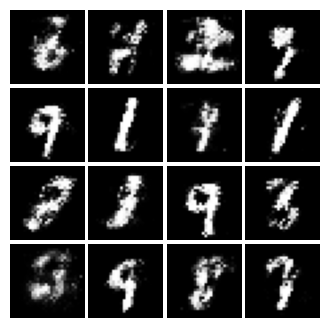

In [331]:
display(Image("best.png"))

In [335]:
# ########################### Training 50 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 50

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

loss_fn = my_bce_loss

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()


100%|██████████| 938/938 [00:14<00:00, 65.89it/s]


epoch 0; D_loss: 0.0768; G_loss: 6.7336
Saved Best Models at epoch 0 | G_loss: 6.7336


100%|██████████| 938/938 [00:12<00:00, 74.82it/s] 


epoch 1; D_loss: 0.0214; G_loss: 6.3371
Saved Best Models at epoch 1 | G_loss: 6.3371


100%|██████████| 938/938 [00:13<00:00, 68.65it/s]


epoch 2; D_loss: 0.0485; G_loss: 5.6012
Saved Best Models at epoch 2 | G_loss: 5.6012


100%|██████████| 938/938 [00:13<00:00, 68.09it/s]


epoch 3; D_loss: 0.0963; G_loss: 5.3302
Saved Best Models at epoch 3 | G_loss: 5.3302


100%|██████████| 938/938 [00:13<00:00, 68.26it/s]


epoch 4; D_loss: 0.1819; G_loss: 4.5048
Saved Best Models at epoch 4 | G_loss: 4.5048


100%|██████████| 938/938 [00:13<00:00, 68.46it/s]


epoch 5; D_loss: 0.3223; G_loss: 3.8692
Saved Best Models at epoch 5 | G_loss: 3.8692


100%|██████████| 938/938 [00:13<00:00, 70.30it/s]


epoch 6; D_loss: 0.3650; G_loss: 3.5727
Saved Best Models at epoch 6 | G_loss: 3.5727


100%|██████████| 938/938 [00:13<00:00, 68.20it/s]


epoch 7; D_loss: 0.4125; G_loss: 3.5586
Saved Best Models at epoch 7 | G_loss: 3.5586


100%|██████████| 938/938 [00:11<00:00, 83.97it/s] 


epoch 8; D_loss: 0.4934; G_loss: 3.1779
Saved Best Models at epoch 8 | G_loss: 3.1779


100%|██████████| 938/938 [00:11<00:00, 81.95it/s] 


epoch 9; D_loss: 0.5304; G_loss: 2.9716
Saved Best Models at epoch 9 | G_loss: 2.9716


100%|██████████| 938/938 [00:10<00:00, 88.70it/s] 


epoch 10; D_loss: 0.5664; G_loss: 2.7627
Saved Best Models at epoch 10 | G_loss: 2.7627


100%|██████████| 938/938 [00:13<00:00, 67.85it/s]


epoch 11; D_loss: 0.5952; G_loss: 2.6481
Saved Best Models at epoch 11 | G_loss: 2.6481


100%|██████████| 938/938 [00:12<00:00, 77.38it/s]


epoch 12; D_loss: 0.6056; G_loss: 2.5893
Saved Best Models at epoch 12 | G_loss: 2.5893


100%|██████████| 938/938 [00:13<00:00, 67.97it/s]


epoch 13; D_loss: 0.6190; G_loss: 2.5304
Saved Best Models at epoch 13 | G_loss: 2.5304


100%|██████████| 938/938 [00:13<00:00, 68.98it/s]


epoch 14; D_loss: 0.6308; G_loss: 2.4492
Saved Best Models at epoch 14 | G_loss: 2.4492


100%|██████████| 938/938 [00:13<00:00, 68.42it/s]


epoch 15; D_loss: 0.6422; G_loss: 2.3807
Saved Best Models at epoch 15 | G_loss: 2.3807


100%|██████████| 938/938 [00:13<00:00, 68.63it/s]


epoch 16; D_loss: 0.6581; G_loss: 2.3361
Saved Best Models at epoch 16 | G_loss: 2.3361


100%|██████████| 938/938 [00:13<00:00, 69.30it/s]


epoch 17; D_loss: 0.6653; G_loss: 2.3148
Saved Best Models at epoch 17 | G_loss: 2.3148


100%|██████████| 938/938 [00:13<00:00, 69.09it/s]


epoch 18; D_loss: 0.6845; G_loss: 2.2648
Saved Best Models at epoch 18 | G_loss: 2.2648


100%|██████████| 938/938 [00:13<00:00, 67.91it/s]


epoch 19; D_loss: 0.7087; G_loss: 2.2180
Saved Best Models at epoch 19 | G_loss: 2.2180


100%|██████████| 938/938 [00:13<00:00, 68.45it/s]


epoch 20; D_loss: 0.7125; G_loss: 2.2232


100%|██████████| 938/938 [00:13<00:00, 68.64it/s]


epoch 21; D_loss: 0.7188; G_loss: 2.1956
Saved Best Models at epoch 21 | G_loss: 2.1956


100%|██████████| 938/938 [00:13<00:00, 68.74it/s]


epoch 22; D_loss: 0.7134; G_loss: 2.1824
Saved Best Models at epoch 22 | G_loss: 2.1824


100%|██████████| 938/938 [00:09<00:00, 96.02it/s] 


epoch 23; D_loss: 0.7170; G_loss: 2.1533
Saved Best Models at epoch 23 | G_loss: 2.1533


100%|██████████| 938/938 [00:10<00:00, 88.75it/s] 


epoch 24; D_loss: 0.7197; G_loss: 2.1512
Saved Best Models at epoch 24 | G_loss: 2.1512


100%|██████████| 938/938 [00:10<00:00, 88.68it/s] 


epoch 25; D_loss: 0.7148; G_loss: 2.1411
Saved Best Models at epoch 25 | G_loss: 2.1411


100%|██████████| 938/938 [00:11<00:00, 78.23it/s] 


epoch 26; D_loss: 0.7180; G_loss: 2.1658


100%|██████████| 938/938 [00:12<00:00, 73.82it/s] 


epoch 27; D_loss: 0.7299; G_loss: 2.1487


100%|██████████| 938/938 [00:13<00:00, 69.05it/s]


epoch 28; D_loss: 0.7223; G_loss: 2.1637


100%|██████████| 938/938 [00:13<00:00, 69.30it/s]


epoch 29; D_loss: 0.7124; G_loss: 2.1838


100%|██████████| 938/938 [00:13<00:00, 68.99it/s]


epoch 30; D_loss: 0.7169; G_loss: 2.2029


100%|██████████| 938/938 [00:13<00:00, 69.05it/s]


epoch 31; D_loss: 0.7114; G_loss: 2.2022


100%|██████████| 938/938 [00:13<00:00, 68.60it/s]


epoch 32; D_loss: 0.7029; G_loss: 2.2163


100%|██████████| 938/938 [00:13<00:00, 68.82it/s]


epoch 33; D_loss: 0.7016; G_loss: 2.2550


100%|██████████| 938/938 [00:13<00:00, 69.75it/s]


epoch 34; D_loss: 0.7004; G_loss: 2.2668


100%|██████████| 938/938 [00:13<00:00, 67.30it/s]


epoch 35; D_loss: 0.6899; G_loss: 2.2914


100%|██████████| 938/938 [00:13<00:00, 69.11it/s]


epoch 36; D_loss: 0.6864; G_loss: 2.3535


100%|██████████| 938/938 [00:13<00:00, 68.27it/s]


epoch 37; D_loss: 0.6747; G_loss: 2.3723


100%|██████████| 938/938 [00:13<00:00, 68.90it/s]


epoch 38; D_loss: 0.6719; G_loss: 2.4034


100%|██████████| 938/938 [00:13<00:00, 68.58it/s]


epoch 39; D_loss: 0.6640; G_loss: 2.4589


100%|██████████| 938/938 [00:13<00:00, 68.29it/s]


epoch 40; D_loss: 0.6570; G_loss: 2.4775


100%|██████████| 938/938 [00:13<00:00, 68.69it/s]


epoch 41; D_loss: 0.6472; G_loss: 2.4996


100%|██████████| 938/938 [00:13<00:00, 67.87it/s]


epoch 42; D_loss: 0.6440; G_loss: 2.5378


100%|██████████| 938/938 [00:13<00:00, 68.44it/s]


epoch 43; D_loss: 0.6431; G_loss: 2.5488


100%|██████████| 938/938 [00:13<00:00, 68.66it/s]


epoch 44; D_loss: 0.6350; G_loss: 2.5955


100%|██████████| 938/938 [00:13<00:00, 68.46it/s]


epoch 45; D_loss: 0.6285; G_loss: 2.5937


100%|██████████| 938/938 [00:13<00:00, 69.26it/s]


epoch 46; D_loss: 0.6204; G_loss: 2.6197


100%|██████████| 938/938 [00:13<00:00, 70.54it/s]


epoch 47; D_loss: 0.6210; G_loss: 2.6545


100%|██████████| 938/938 [00:13<00:00, 68.72it/s]


epoch 48; D_loss: 0.6178; G_loss: 2.6659


100%|██████████| 938/938 [00:13<00:00, 69.35it/s]


epoch 49; D_loss: 0.6130; G_loss: 2.6778


D_loss,▂▁▁▂▃▄▅▆▆▆▇▇▇▇▇███████████████▇▇▇▇▇▇▇▇▇▇
G_loss,█▇▆▆▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
D_loss,0.61299
G_loss,2.67781
epoch,49


In [336]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)

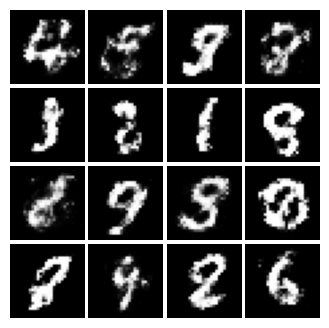

In [337]:
display(Image("best.png"))

## Task 2

Run the same code with a different loss function: Logistic loss as described in Brandon
Amos blog and compare the results with above Task 1.

In [351]:
########################################################################
    # Logistic loss. Change "out" in Discriminator and Loss Function
########################################################################
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))   # in Generator we spare Sigmoid because the data is in [0,1]
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        # out = torch.sigmoid(self.fc2(h))    # before change 
        out = self.fc2(h)                     # after change to logistic loss
        return out

In [352]:
# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())  # fake discrimination 

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)  # more 1 for fakes from D, better for G
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    """wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })"""

    return G, D, G_loss_avg, D_loss_avg

In [353]:
# Generator stopps to learn and only generates pictures
def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_vanila_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]    # We don't need to see all 64, 16 is enough to see progress

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)


In [342]:
########################### 5 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 5

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function

#def my_bce_loss(preds, targets):
#    return F.binary_cross_entropy(preds, targets)
# loss_fn = my_bce_loss                               # Before change

# Binary Cross Entropy loss function 
loss_fn = nn.BCEWithLogitsLoss()                      # After change. Includes Sigmoid by itself


best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()

100%|██████████| 938/938 [00:13<00:00, 70.13it/s]


epoch 0; D_loss: 0.0740; G_loss: 5.6233
Saved Best Models at epoch 0 | G_loss: 5.6233


100%|██████████| 938/938 [00:13<00:00, 69.22it/s]


epoch 1; D_loss: 0.0390; G_loss: 5.6985


100%|██████████| 938/938 [00:13<00:00, 68.91it/s]


epoch 2; D_loss: 0.0708; G_loss: 5.2928
Saved Best Models at epoch 2 | G_loss: 5.2928


100%|██████████| 938/938 [00:13<00:00, 69.73it/s]


epoch 3; D_loss: 0.0932; G_loss: 5.5476


100%|██████████| 938/938 [00:11<00:00, 80.15it/s] 


epoch 4; D_loss: 0.1756; G_loss: 5.1592
Saved Best Models at epoch 4 | G_loss: 5.1592


D_loss,▃▁▃▄█
G_loss,▇█▃▆▁
epoch,▁▃▅▆█
D_loss,0.17563
G_loss,5.15918
epoch,4


In [343]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)


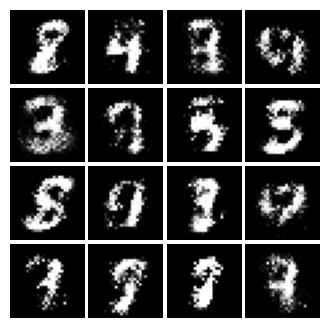

In [344]:
display(Image("best.png"))

In [348]:
########################### 10 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 10

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function

#def my_bce_loss(preds, targets):
#    return F.binary_cross_entropy(preds, targets)
# loss_fn = my_bce_loss                               # Before change

# Binary Cross Entropy loss function 
loss_fn = nn.BCEWithLogitsLoss()                      # After change. Includes Sigmoid by itself


best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()

100%|██████████| 938/938 [00:11<00:00, 80.79it/s] 


epoch 0; D_loss: 0.0888; G_loss: 5.6969
Saved Best Models at epoch 0 | G_loss: 5.6969


100%|██████████| 938/938 [00:13<00:00, 69.92it/s]


epoch 1; D_loss: 0.0522; G_loss: 5.2435
Saved Best Models at epoch 1 | G_loss: 5.2435


100%|██████████| 938/938 [00:13<00:00, 70.07it/s]


epoch 2; D_loss: 0.0949; G_loss: 5.1644
Saved Best Models at epoch 2 | G_loss: 5.1644


100%|██████████| 938/938 [00:13<00:00, 69.71it/s]


epoch 3; D_loss: 0.1730; G_loss: 4.9711
Saved Best Models at epoch 3 | G_loss: 4.9711


100%|██████████| 938/938 [00:13<00:00, 68.89it/s]


epoch 4; D_loss: 0.2821; G_loss: 4.2548
Saved Best Models at epoch 4 | G_loss: 4.2548


100%|██████████| 938/938 [00:13<00:00, 69.13it/s]


epoch 5; D_loss: 0.3571; G_loss: 4.1867
Saved Best Models at epoch 5 | G_loss: 4.1867


100%|██████████| 938/938 [00:13<00:00, 70.63it/s]


epoch 6; D_loss: 0.4503; G_loss: 3.3656
Saved Best Models at epoch 6 | G_loss: 3.3656


100%|██████████| 938/938 [00:13<00:00, 69.46it/s]


epoch 7; D_loss: 0.5352; G_loss: 3.0023
Saved Best Models at epoch 7 | G_loss: 3.0023


100%|██████████| 938/938 [00:13<00:00, 69.84it/s]


epoch 8; D_loss: 0.5776; G_loss: 2.8231
Saved Best Models at epoch 8 | G_loss: 2.8231


100%|██████████| 938/938 [00:13<00:00, 69.18it/s]


epoch 9; D_loss: 0.6024; G_loss: 2.7423
Saved Best Models at epoch 9 | G_loss: 2.7423


D_loss,▁▁▂▃▄▅▆▇██
G_loss,█▇▇▆▅▄▂▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
D_loss,0.60236
G_loss,2.74228
epoch,9


In [349]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)


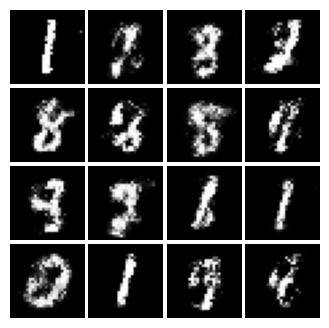

In [350]:
display(Image("best.png"))

In [354]:
########################### 50 epochs #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of epochs (change only here)
epochs = 50

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function

#def my_bce_loss(preds, targets):
#    return F.binary_cross_entropy(preds, targets)
# loss_fn = my_bce_loss                               # Before change

# Binary Cross Entropy loss function 
loss_fn = nn.BCEWithLogitsLoss()                      # After change. Includes Sigmoid by itself


best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Initialize W&B immediately before training
if wandb_log: 
    wandb.init(
        project="conditional-gan-mnist",
        name=f"run_{epochs}_epochs",
        settings=wandb.Settings(start_method="thread"),
        config={
            "batch_size": mb_size,
            "Z_dim": Z_dim,
            "X_dim": X_dim,
            "h_dim": h_dim,
            "lr": lr,
            "epochs": epochs,
            "start_epoch": 0,
            "end_epoch": epochs - 1
        }
    )

# Train loop
for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg = cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if wandb_log:
        wandb.log({
            "epoch": epoch,
            "D_loss": D_loss_avg,
            "G_loss": G_loss_avg
        })

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)

# Final log and run closure
if wandb_log:
    wandb.config.update({"final_epoch": epoch})  # saved in config metadata
    wandb.finish()

100%|██████████| 938/938 [00:10<00:00, 93.26it/s] 


epoch 0; D_loss: 0.0835; G_loss: 8.8103
Saved Best Models at epoch 0 | G_loss: 8.8103


100%|██████████| 938/938 [00:13<00:00, 68.93it/s]


epoch 1; D_loss: 0.0198; G_loss: 9.1491


100%|██████████| 938/938 [00:13<00:00, 69.31it/s]


epoch 2; D_loss: 0.0126; G_loss: 8.7180
Saved Best Models at epoch 2 | G_loss: 8.7180


100%|██████████| 938/938 [00:13<00:00, 69.13it/s]


epoch 3; D_loss: 0.0181; G_loss: 6.8026
Saved Best Models at epoch 3 | G_loss: 6.8026


100%|██████████| 938/938 [00:13<00:00, 71.81it/s]


epoch 4; D_loss: 0.0274; G_loss: 7.2899


100%|██████████| 938/938 [00:13<00:00, 70.28it/s]


epoch 5; D_loss: 0.0815; G_loss: 5.7900
Saved Best Models at epoch 5 | G_loss: 5.7900


100%|██████████| 938/938 [00:13<00:00, 70.46it/s]


epoch 6; D_loss: 0.1615; G_loss: 5.0367
Saved Best Models at epoch 6 | G_loss: 5.0367


100%|██████████| 938/938 [00:13<00:00, 70.65it/s]


epoch 7; D_loss: 0.2987; G_loss: 4.1275
Saved Best Models at epoch 7 | G_loss: 4.1275


100%|██████████| 938/938 [00:13<00:00, 69.34it/s]


epoch 8; D_loss: 0.3913; G_loss: 3.6707
Saved Best Models at epoch 8 | G_loss: 3.6707


100%|██████████| 938/938 [00:13<00:00, 69.82it/s]


epoch 9; D_loss: 0.4235; G_loss: 3.3346
Saved Best Models at epoch 9 | G_loss: 3.3346


100%|██████████| 938/938 [00:13<00:00, 70.45it/s]


epoch 10; D_loss: 0.4578; G_loss: 3.0570
Saved Best Models at epoch 10 | G_loss: 3.0570


100%|██████████| 938/938 [00:13<00:00, 69.54it/s]


epoch 11; D_loss: 0.4946; G_loss: 2.9179
Saved Best Models at epoch 11 | G_loss: 2.9179


100%|██████████| 938/938 [00:13<00:00, 70.66it/s]


epoch 12; D_loss: 0.5214; G_loss: 2.7056
Saved Best Models at epoch 12 | G_loss: 2.7056


100%|██████████| 938/938 [00:13<00:00, 69.75it/s]


epoch 13; D_loss: 0.5338; G_loss: 2.6232
Saved Best Models at epoch 13 | G_loss: 2.6232


100%|██████████| 938/938 [00:13<00:00, 69.38it/s]


epoch 14; D_loss: 0.5738; G_loss: 2.6669


100%|██████████| 938/938 [00:13<00:00, 69.10it/s]


epoch 15; D_loss: 0.6171; G_loss: 2.5272
Saved Best Models at epoch 15 | G_loss: 2.5272


100%|██████████| 938/938 [00:13<00:00, 69.70it/s]


epoch 16; D_loss: 0.6255; G_loss: 2.4808
Saved Best Models at epoch 16 | G_loss: 2.4808


100%|██████████| 938/938 [00:13<00:00, 69.90it/s]


epoch 17; D_loss: 0.6208; G_loss: 2.4499
Saved Best Models at epoch 17 | G_loss: 2.4499


100%|██████████| 938/938 [00:13<00:00, 69.80it/s]


epoch 18; D_loss: 0.6155; G_loss: 2.4329
Saved Best Models at epoch 18 | G_loss: 2.4329


100%|██████████| 938/938 [00:12<00:00, 73.23it/s]


epoch 19; D_loss: 0.6024; G_loss: 2.4720


100%|██████████| 938/938 [00:13<00:00, 69.25it/s]


epoch 20; D_loss: 0.5953; G_loss: 2.5239


100%|██████████| 938/938 [00:13<00:00, 70.63it/s]


epoch 21; D_loss: 0.5968; G_loss: 2.5443


100%|██████████| 938/938 [00:13<00:00, 70.26it/s]


epoch 22; D_loss: 0.5945; G_loss: 2.5829


100%|██████████| 938/938 [00:12<00:00, 74.82it/s] 


epoch 23; D_loss: 0.5915; G_loss: 2.5961


100%|██████████| 938/938 [00:13<00:00, 69.50it/s]


epoch 24; D_loss: 0.5824; G_loss: 2.6527


100%|██████████| 938/938 [00:13<00:00, 69.79it/s]


epoch 25; D_loss: 0.5757; G_loss: 2.6931


100%|██████████| 938/938 [00:13<00:00, 69.51it/s]


epoch 26; D_loss: 0.5637; G_loss: 2.7397


100%|██████████| 938/938 [00:13<00:00, 69.07it/s]


epoch 27; D_loss: 0.5652; G_loss: 2.7316


100%|██████████| 938/938 [00:13<00:00, 68.77it/s]


epoch 28; D_loss: 0.5567; G_loss: 2.7804


100%|██████████| 938/938 [00:13<00:00, 70.91it/s]


epoch 29; D_loss: 0.5467; G_loss: 2.8096


100%|██████████| 938/938 [00:11<00:00, 78.22it/s] 


epoch 30; D_loss: 0.5437; G_loss: 2.8319


100%|██████████| 938/938 [00:13<00:00, 69.51it/s]


epoch 31; D_loss: 0.5380; G_loss: 2.8523


100%|██████████| 938/938 [00:13<00:00, 69.78it/s]


epoch 32; D_loss: 0.5293; G_loss: 2.8562


100%|██████████| 938/938 [00:13<00:00, 69.21it/s]


epoch 33; D_loss: 0.5292; G_loss: 2.9065


100%|██████████| 938/938 [00:13<00:00, 70.23it/s]


epoch 34; D_loss: 0.5277; G_loss: 2.9144


100%|██████████| 938/938 [00:13<00:00, 69.08it/s]


epoch 35; D_loss: 0.5256; G_loss: 2.9386


100%|██████████| 938/938 [00:13<00:00, 69.94it/s]


epoch 36; D_loss: 0.5223; G_loss: 2.9751


100%|██████████| 938/938 [00:13<00:00, 69.35it/s]


epoch 37; D_loss: 0.5210; G_loss: 2.9779


100%|██████████| 938/938 [00:11<00:00, 80.23it/s] 


epoch 38; D_loss: 0.5166; G_loss: 2.9912


100%|██████████| 938/938 [00:09<00:00, 93.81it/s] 


epoch 39; D_loss: 0.5147; G_loss: 2.9991


100%|██████████| 938/938 [00:10<00:00, 86.46it/s] 


epoch 40; D_loss: 0.5145; G_loss: 3.0115


100%|██████████| 938/938 [00:12<00:00, 76.34it/s] 


epoch 41; D_loss: 0.5133; G_loss: 3.0532


100%|██████████| 938/938 [00:12<00:00, 72.71it/s] 


epoch 42; D_loss: 0.5157; G_loss: 3.0293


100%|██████████| 938/938 [00:12<00:00, 75.68it/s] 


epoch 43; D_loss: 0.5148; G_loss: 3.0510


100%|██████████| 938/938 [00:13<00:00, 69.81it/s]


epoch 44; D_loss: 0.5121; G_loss: 3.0230


100%|██████████| 938/938 [00:11<00:00, 81.00it/s] 


epoch 45; D_loss: 0.5142; G_loss: 3.0310


100%|██████████| 938/938 [00:13<00:00, 70.75it/s]


epoch 46; D_loss: 0.5071; G_loss: 3.0338


100%|██████████| 938/938 [00:11<00:00, 78.33it/s] 


epoch 47; D_loss: 0.5099; G_loss: 3.0549


100%|██████████| 938/938 [00:13<00:00, 69.81it/s]


epoch 48; D_loss: 0.5078; G_loss: 3.0810


100%|██████████| 938/938 [00:13<00:00, 70.20it/s]


epoch 49; D_loss: 0.5034; G_loss: 3.0606


D_loss,▂▁▁▁▁▃▄▅▆▆▇▇▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
G_loss,███▆▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
D_loss,0.50336
G_loss,3.0606
epoch,49


In [355]:
# Inference / sampling from the best‐saved G

# 1) Re‐create the Generator and move to the same device
G_infer = Generator(Z_dim, h_dim, X_dim).to(device)

# 2) Load the weights from the best checkpoint
checkpoint = torch.load('checkpoints/G_best.pth', map_location=device, weights_only=True)
G_infer.load_state_dict(checkpoint)

# 3) Set to evaluation mode
G_infer.eval()

# 4) Generate and save a sample grid (this will create out_vanila_GAN2/best.png)
save_sample(G_infer, "best", mb_size, Z_dim)

# 5) Clean previous best models
for f in glob.glob(os.path.join(save_dir, "G_best_epoch*.pth")):
    os.remove(f)


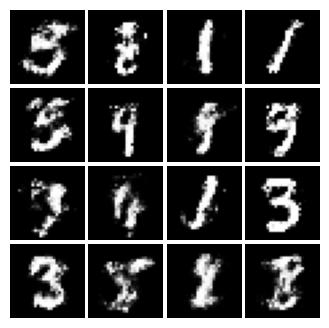

In [356]:
display(Image("best.png"))


# Results Comparison (5, 10, 50 epochs)

Two Loss Functions:


**Manual BCE**
→ F.binary_cross_entropy(torch.sigmoid(logits), targets)


**Logistic**
→ nn.BCEWithLogitsLoss()

| Epochs | Loss Function   | D_loss   | G_loss   | Observations                                                             |
|--------|-----------------|----------|----------|---------------------------------------------------------------------------|
| 5      | Manual BCE      | 0.10418  | 5.63655  | Discriminator very strong out of the gate (low D_loss), generator still producing random-ish noise. |
|        | BCEWithLogits   | 0.17563  | 5.15918  | Both in early unstable phase; D slightly weaker, G a bit better than Manual BCE. |
| 10      | Manual BCE      | 0.62129  | 2.75248  | D and G moving toward balance; generator loss has dropped sharply.        |
|        | BCEWithLogits   | 0.60236  | 2.74228  | Similar behavior; D_loss progression is smoother and slightly closer to the ideal 0.693. |
| 50     | Manual BCE      | 0.61299  | 2.67781  | Near equilibrium region—D just a bit strong, G continuing gradual improvement. |
|        | BCEWithLogits   | 0.50336  | 3.06060  | D has become too dominant (D_loss ≪ 0.69), stalling G’s progress (higher G_loss). |




### Goodfellow’s original GAN (sigmoid + binary cross-entropy)

Uses a sigmoid at the discriminator’s output to produce values in [0,1], which are interpreted as “probabilities.”

*Side effect*: when logits become large in magnitude, the sigmoid saturates, causing the loss to “flatten out” and produce a very smooth training curve.

### Brandon Amos approache (Logits + BCEWithLogitsLoss)

Drops the explicit sigmoid and feeds raw logits into a fused sigmoid-plus-cross-entropy operation for better numerical stability.

*Side effect*: we see every fluctuation in the logits reflected in the loss, so the curve often appears jumpier or more “noisy.”

### Which should be smoother?

If our goal is a visually smooth, flattened loss curve, the Goodfellow variant with an explicit sigmoid will look smoother.

If we want the most robust gradients and true reflection of the discriminator’s confidence (even if the curve is noisier), the logits + BCEWithLogitsLoss approach is preferred.